In [1]:
from mel_processing import get_melspec_from_file, calc_deltas
import os
import glob
import IPython
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

## データセット内の音声ファイルの平均の長さを計算

Shape of waveform: torch.Size([1, 43008])
Sample rate of waveform: 16000


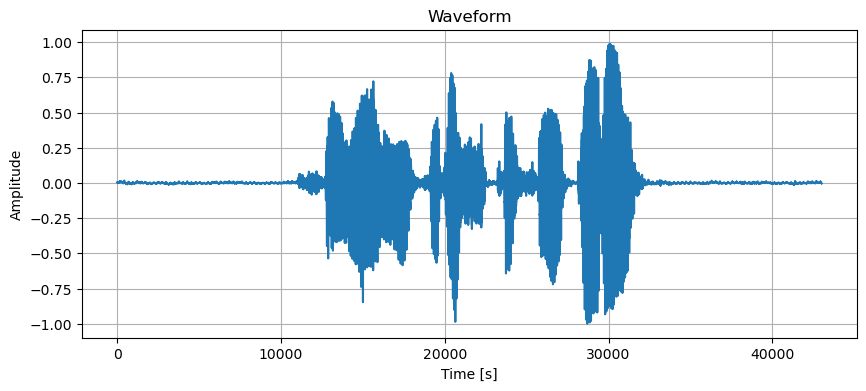

Shape of spec: torch.Size([1, 64, 301])


In [2]:
# filename = 'dataset/esd/0012/Neutral/0012_000001.wav'
# filename = 'dataset/esd/0015/Happy/0015_000830.wav'
filename ='/work/abelab5/t_tana/emo_clf2/dataset/jtes/wav/m14/joy/m14_joy_01.wav'
waveform, sr = torchaudio.load(filepath=filename)
sec_per_sample = 1 / sr
# 波形の形状とサンプルレートの表示
print(f"Shape of waveform: {waveform.size()}")
print(f"Sample rate of waveform: {sr}")
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.title('Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

log_melspec = get_melspec_from_file(filename, 3.0, False, 25e-3, 10e-3, 25e-3, 64)
log_melspec_emph = get_melspec_from_file(filename, 3.0, True, 25e-3, 10e-3, 25e-3, 64)

print(f"Shape of spec: {log_melspec.size()}")

IPython.display.Audio(filename)



In [3]:
dataset = 'dataset/jtes'
wavpath_list = glob.glob(os.path.join(dataset, '**', '*.wav'), recursive=True)
neutral_list = [wavpath for wavpath in wavpath_list if 'Neutral' in wavpath or 'neu' in wavpath]
happy_list = [wavpath for wavpath in wavpath_list if 'Happy' in wavpath or 'joy' in wavpath]
sad_list = [wavpath for wavpath in wavpath_list if 'Sad' in wavpath or 'sad' in wavpath]
angry_list = [wavpath for wavpath in wavpath_list if 'Angry' in wavpath or 'ang' in wavpath]
surprise_list = [wavpath for wavpath in wavpath_list if 'Surprise' in wavpath]
all_dict = {'Neutral':neutral_list, 'Happy':happy_list, 'Sad':sad_list, 'Angry':angry_list, 'Surprise':surprise_list}
emotions = ['Neutral', 'Happy', 'Sad', 'Angry', 'Surprise']
for emotion in emotions:
    print(f'{len(all_dict[emotion])=}')

len(all_dict[emotion])=5000
len(all_dict[emotion])=5000
len(all_dict[emotion])=5000
len(all_dict[emotion])=5000
len(all_dict[emotion])=0


In [8]:
def calc_n_sample_from_file(filename):
    waveform, sr = torchaudio.load(filepath=filename)
    n_sample = waveform.size(1)
    return n_sample

# Surpriseをのぞく音声の平均長を計算
wavpath_list_without_surprise = [wavpath for wavpath in wavpath_list if 'Surprise' not in wavpath]
ave_n_sample = 0
for file in wavpath_list_without_surprise:
    ave_n_sample += calc_n_sample_from_file(file)
ave_n_sample //= len(wavpath_list_without_surprise)
ave_sec = ave_n_sample*sec_per_sample
print(f'{ave_n_sample=}')
print(f'{ave_sec=}')


KeyboardInterrupt: 

# 波形とメルスペクトログラム，そのdeltaとdelta-delta特徴量で構成される3D-MelSpectrogram
論文（https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2021.643202/full ）を参考に実装．

In [4]:
def plot_melspectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

# メルスペクトログラム，delta，delta-delta
あらかじめ波形をpre-emphasize(高域強調を適用)しておく．以降はこの波形を使用したメルスペクトログラムを使用．

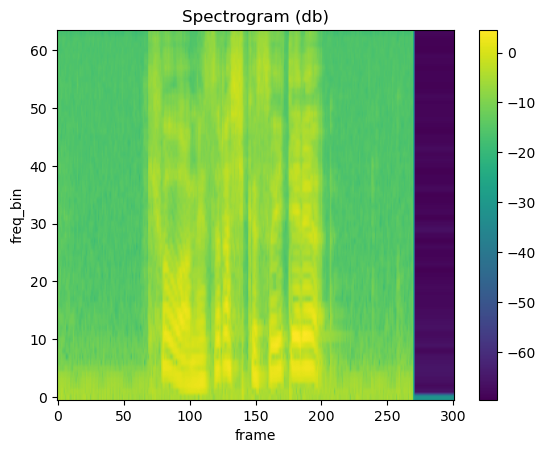

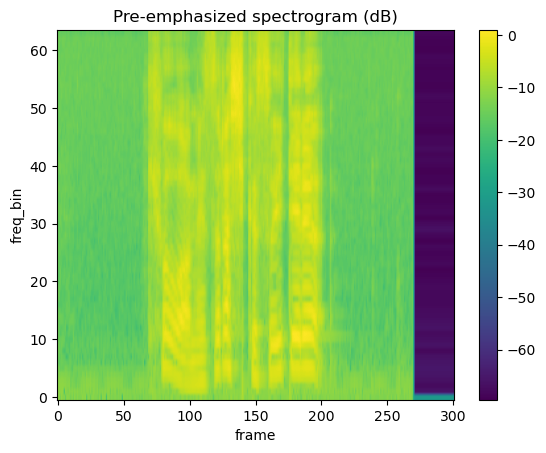

In [5]:
plot_melspectrogram(log_melspec[0])
plot_melspectrogram(log_melspec_emph[0], title='Pre-emphasized spectrogram (dB)')


torch.Size([3, 64, 301])


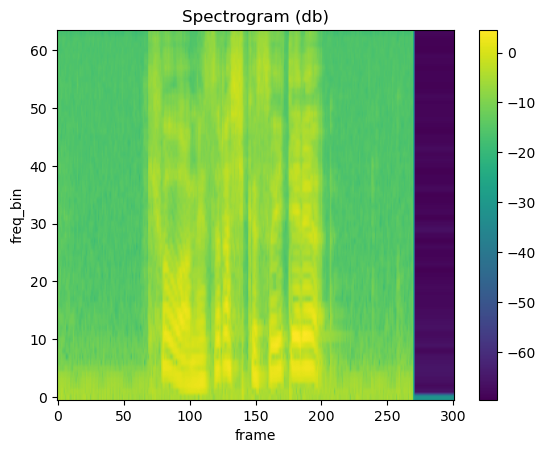

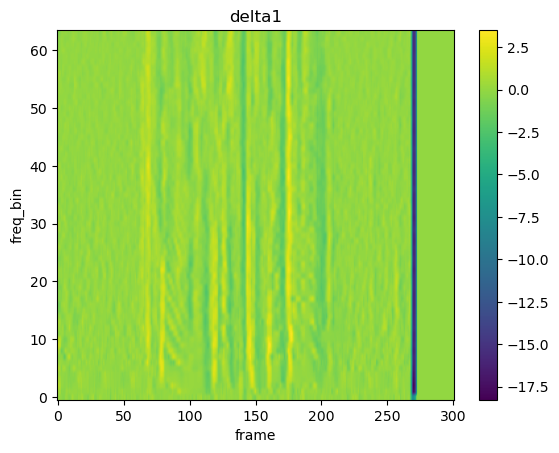

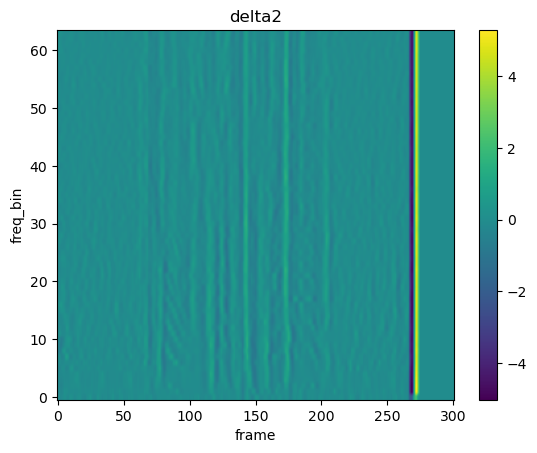

In [6]:
mel_specs_3d = calc_deltas(log_melspec)
print(mel_specs_3d.size())
plot_melspectrogram(mel_specs_3d[0])
plot_melspectrogram(mel_specs_3d[1], title='delta1')
plot_melspectrogram(mel_specs_3d[2], title='delta2')


# 3つの特徴量を重ねて，同じサイズのセグメントに分割
- normalize として0-1で正規化した場合

In [7]:
from preprocess import extract_resized_segments_from_file

In [8]:
import cv2
import matplotlib.pyplot as plt

def imgShow(imgList, row_num = 1):
    img_num = len(imgList)
    
    if img_num == 1:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(imgList[0])
    
    else:
        fig, axes = plt.subplots(row_num, round(img_num / row_num))
        ax = axes.ravel()
        for i in range(img_num):
            ax[i].imshow(imgList[i])

    plt.show()

def show_segments(filename, normalizer=None, max_sec=3.0):
    segments = extract_resized_segments_from_file(filename, normalizer=normalizer, max_sec=max_sec)
    print(f'{segments.size()=}')
    imgs = [segments[idx].permute(*torch.arange(segments[idx].ndim - 1, -1, -1)) for idx in range(segments.size(0))]
    imgShow(imgs)
    return segments

学習スクリプトの実装では最大長は全音声の平均長ではなく，3sにしているが，以下はデータセットの平均長を最大長にしているため，7枚の画像になる．（3sの場合は8枚になる）

segments.size()=torch.Size([11, 3, 227, 227])


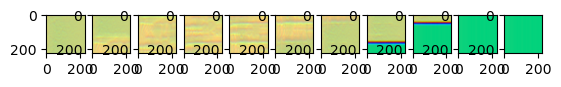

tensor([[[0.8374, 0.8374, 0.8280,  ..., 0.8038, 0.8052, 0.8052],
         [0.8374, 0.8374, 0.8280,  ..., 0.8038, 0.8052, 0.8052],
         [0.8326, 0.8326, 0.8262,  ..., 0.8055, 0.8063, 0.8063],
         ...,
         [0.8798, 0.8798, 0.8769,  ..., 0.7687, 0.7689, 0.7689],
         [0.8815, 0.8815, 0.8783,  ..., 0.7646, 0.7649, 0.7649],
         [0.8815, 0.8815, 0.8783,  ..., 0.7646, 0.7649, 0.7649]],

        [[0.8095, 0.8095, 0.8122,  ..., 0.8160, 0.8112, 0.8112],
         [0.8095, 0.8095, 0.8122,  ..., 0.8160, 0.8112, 0.8112],
         [0.8164, 0.8164, 0.8183,  ..., 0.8198, 0.8165, 0.8165],
         ...,
         [0.8165, 0.8165, 0.8129,  ..., 0.8258, 0.8262, 0.8262],
         [0.8176, 0.8176, 0.8135,  ..., 0.8275, 0.8288, 0.8288],
         [0.8176, 0.8176, 0.8135,  ..., 0.8275, 0.8288, 0.8288]],

        [[0.4830, 0.4830, 0.4870,  ..., 0.5018, 0.5013, 0.5013],
         [0.4830, 0.4830, 0.4870,  ..., 0.5018, 0.5013, 0.5013],
         [0.4871, 0.4871, 0.4897,  ..., 0.5023, 0.5022, 0.

In [9]:
segments = show_segments(filename, max_sec=4)
print(segments[6])

- 0-1normalize + ImageNetの設定でnormalizeの場合

注）RGBの値ではないので正常に表示不可能

In [15]:
import torchvision.transforms as T

segments.size()=torch.Size([9, 3, 227, 227])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


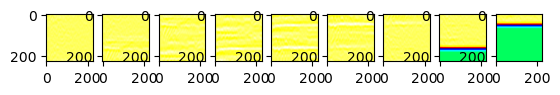

tensor([[[1.5390, 1.5390, 1.4980,  ..., 1.3921, 1.3982, 1.3982],
         [1.5390, 1.5390, 1.4980,  ..., 1.3921, 1.3982, 1.3982],
         [1.5180, 1.5180, 1.4899,  ..., 1.3995, 1.4032, 1.4032],
         ...,
         [1.7242, 1.7242, 1.7114,  ..., 1.2390, 1.2398, 1.2398],
         [1.7313, 1.7313, 1.7174,  ..., 1.2210, 1.2224, 1.2224],
         [1.7313, 1.7313, 1.7174,  ..., 1.2210, 1.2224, 1.2224]],

        [[1.5782, 1.5782, 1.5900,  ..., 1.6070, 1.5855, 1.5855],
         [1.5782, 1.5782, 1.5900,  ..., 1.6070, 1.5855, 1.5855],
         [1.6089, 1.6089, 1.6172,  ..., 1.6242, 1.6096, 1.6096],
         ...,
         [1.6092, 1.6092, 1.5932,  ..., 1.6509, 1.6527, 1.6527],
         [1.6142, 1.6142, 1.5959,  ..., 1.6586, 1.6643, 1.6643],
         [1.6142, 1.6142, 1.5959,  ..., 1.6586, 1.6643, 1.6643]],

        [[0.3422, 0.3422, 0.3599,  ..., 0.4256, 0.4237, 0.4237],
         [0.3422, 0.3422, 0.3599,  ..., 0.4256, 0.4237, 0.4237],
         [0.3605, 0.3605, 0.3721,  ..., 0.4279, 0.4274, 0.

In [16]:
segments = show_segments(filename, normalizer=T.Normalize(mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), max_sec=ave_sec)
print(segments[6])

# その他の音声を見る

- 同じ文で同じ感情，異なる話者の場合

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0017/Angry/0017_000351.wav ↓


segments.size()=torch.Size([7, 3, 227, 227])


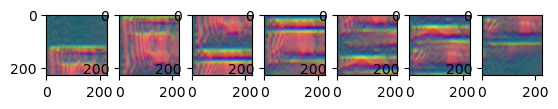

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0018/Angry/0018_000351.wav ↓


segments.size()=torch.Size([7, 3, 227, 227])


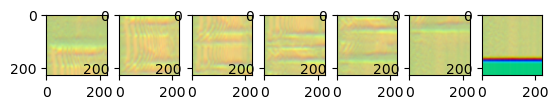

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0012/Angry/0012_000351.wav ↓


segments.size()=torch.Size([7, 3, 227, 227])


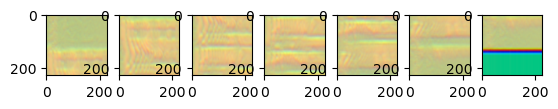

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Angry/0020_000351.wav ↓


segments.size()=torch.Size([7, 3, 227, 227])


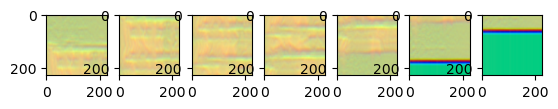

In [51]:
filelist = ['/work/abelab5/t_tana/emo_clf2/dataset/esd/0017/Angry/0017_000351.wav', 
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0018/Angry/0018_000351.wav',
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0012/Angry/0012_000351.wav', 
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Angry/0020_000351.wav',]

for file in filelist:
    print(f'listen {file} ↓')
    IPython.display.display(IPython.display.Audio(file))
    show_segments(file, max_sec=ave_sec)

- 同じ文で同じ話者，感情が異なる場合

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Angry/0020_000359.wav ↓


segments.size()=torch.Size([7, 3, 227, 227])


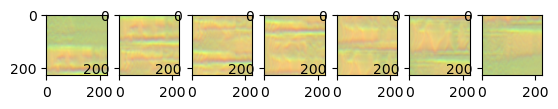

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Happy/0020_000709.wav ↓


segments.size()=torch.Size([7, 3, 227, 227])


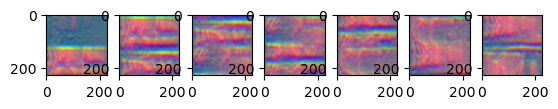

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Neutral/0020_000009.wav ↓


segments.size()=torch.Size([7, 3, 227, 227])


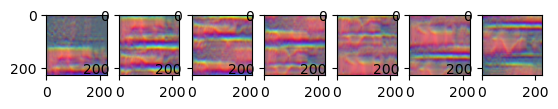

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Sad/0020_001059.wav ↓


segments.size()=torch.Size([7, 3, 227, 227])


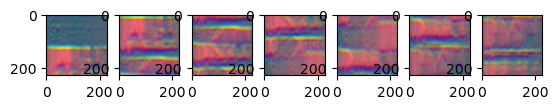

In [52]:
filelist = ['/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Angry/0020_000359.wav',
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Happy/0020_000709.wav', 
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Neutral/0020_000009.wav',
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Sad/0020_001059.wav']

for file in filelist:
    print(f'listen {file} ↓')
    IPython.display.display(IPython.display.Audio(file))
    show_segments(file, max_sec=ave_sec)